In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
from bnb.problem import OptimizationProblem
from scipy.optimize import minimize
from bnb.fml_solver import FMLSolver
from bnb.gradient_descent import GradientDescent
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set()
matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif'})

### Solve with FML when true demand has segement-specific price sensitivity

In [3]:
seed = 1
n, m = 50, 2
a_range = (-7, 7)
b_range = (0.001, 0.01)
np.random.seed(seed)

def segment_purchase_probabiliy(p, a, b):
    utilities = a - b * p
    return np.exp(utilities) / (1 + np.sum(np.exp(utilities)))

def revenue_segment_specific_price_sensitivity(p, w, a, b):
    return - np.sum([
        w[c] *
        np.sum(p * segment_purchase_probabiliy(p, a[c], b[c]))
        for c in range(m)
    ])

results = []

for _ in range(50):
 
    w = np.random.uniform(0, 1, size=m)
    w /= np.sum(w)
    a = [np.random.uniform(*a_range, size=n) for _ in range(m)]
    b = np.random.uniform(*b_range, size=n)
    problem = OptimizationProblem(a, b, w)

    # solve with gradient descent
    gd = GradientDescent(a, b, w)
    gd_sol = gd.solve()

    # solve with our solver
    solver = FMLSolver(problem, objective_lb=gd_sol, multiprocess=True, epsilon=0.01)
    solver.solve()
    
    i_max = np.argmax([cube.objective_lb for cube in solver.cubes])
    cube = solver.cubes[i_max]
    theta = solver._minimize_dual_lipschitz_bound(cube, cube.center).x
    z_opt = cube.z_opt
    p_opt_fml = - np.log(cube.z_opt) / problem.b
        
    for delta in np.linspace(0.0, 0.5, 10):

        b_perturbed = [b * (1 - delta), b * (1 + delta)]
        args = (w, a, b_perturbed)
        max_ = -np.inf

        for _ in range(5):

            p_start = np.random.uniform(problem.p_lb, problem.p_ub)
            with np.errstate(all="ignore"):
                opt = minimize(
                    revenue_segment_specific_price_sensitivity,
                    p_start,
                    args=args,
                    options={"gtol": 1e-03},
                )
            if -opt.fun > max_:
                max_ = -opt.fun

        true_rev = max_
        fml_rev = - revenue_segment_specific_price_sensitivity(p_opt_fml, *args)
        results.append({"delta": delta, "true_rev": true_rev, "fml_rev": fml_rev})

### Visualize results

In [4]:
import pandas as pd
df = (
    pd.DataFrame.from_records(results)
    .assign(opt_gap=lambda df: 100 * (1 - df["fml_rev"] / df["true_rev"]))
)

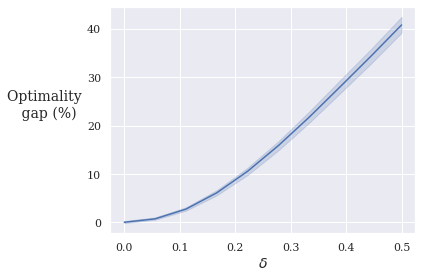

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=df, x="delta", y="opt_gap", ci=95, ax=ax)
ax.set_xlabel(r"$\delta$", size=14)
ax.set_ylabel("Optimality \n gap (%)", size=14, rotation=0, labelpad=40)
plt.tight_layout()
plt.savefig("segment-specific-price-sensitivities.pdf")
plt.show()